This project works through the basics of importing stock data using the Pandas framework. We manipulate the data - attempting to find an investing strategy - apply machine learning and deep learning, and back-test our strategy

Importing the necessary libraries

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web

In [2]:
style.use('ggplot')
start = dt.datetime(2015,1,1)
end = dt.datetime.now()

'start' and 'end' datetime objects define the range of dates we grab the stock price information for.

In [3]:
df = web.DataReader("TSLA",'yahoo',start,end)

This used the pandas_datareader package to look for the stock ticker TSLA, gets the information from yahoo, in our defined time range. 'df' now contains stock pricing information for Tesla.

## Data exploration

In [4]:
print(df.head())

                 High        Low       Open      Close      Volume  Adj Close
Date                                                                         
2014-12-31  45.136002  44.450001  44.618000  44.481998  11487500.0  44.481998
2015-01-02  44.650002  42.652000  44.574001  43.862000  23822000.0  43.862000
2015-01-05  43.299999  41.431999  42.910000  42.018002  26842500.0  42.018002
2015-01-06  42.840000  40.841999  42.012001  42.256001  31309500.0  42.256001
2015-01-07  42.956001  41.956001  42.669998  42.189999  14842000.0  42.189999


High: highest value over the course of the trading day
Low: lowest value over the course of the trading day
Open: price of 1 share when the stock market opens in the morning for trading
Close: closing value of share at the end of the trading day
Volume: number of shares traded on the trading day
Adj close: accounts for future stock splits, and gives the relative price to splits. 


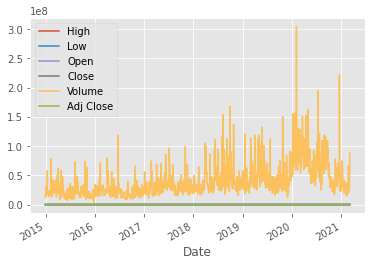

In [5]:
# df.to_csv('TSLA.csv')
# df = pd.read_csv('TSLA.csv',parse_dates=True,index_col=0)
df.plot()
plt.show()

This graphs the volume.

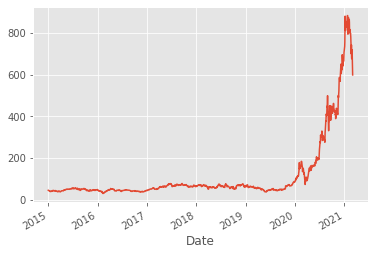

In [6]:
df['Adj Close'].plot()
plt.show()

**Finding 100-day rolling moving average of the data**


In [7]:
df['100ma'] = df['Adj Close'].rolling(window=100).mean()

In [8]:
print(df.head())

                 High        Low       Open      Close      Volume  Adj Close  \
Date                                                                            
2014-12-31  45.136002  44.450001  44.618000  44.481998  11487500.0  44.481998   
2015-01-02  44.650002  42.652000  44.574001  43.862000  23822000.0  43.862000   
2015-01-05  43.299999  41.431999  42.910000  42.018002  26842500.0  42.018002   
2015-01-06  42.840000  40.841999  42.012001  42.256001  31309500.0  42.256001   
2015-01-07  42.956001  41.956001  42.669998  42.189999  14842000.0  42.189999   

            100ma  
Date               
2014-12-31    NaN  
2015-01-02    NaN  
2015-01-05    NaN  
2015-01-06    NaN  
2015-01-07    NaN  


We get missing values because, theoretically, need 100 _prior_ datapoints to compute 100-day rolling moving average.
One workaround is changing the minimum periods parameter

In [9]:
df['100ma'] = df['Adj Close'].rolling(window=100,min_periods=0).mean()
print(df.head())

                 High        Low       Open      Close      Volume  Adj Close  \
Date                                                                            
2014-12-31  45.136002  44.450001  44.618000  44.481998  11487500.0  44.481998   
2015-01-02  44.650002  42.652000  44.574001  43.862000  23822000.0  43.862000   
2015-01-05  43.299999  41.431999  42.910000  42.018002  26842500.0  42.018002   
2015-01-06  42.840000  40.841999  42.012001  42.256001  31309500.0  42.256001   
2015-01-07  42.956001  41.956001  42.669998  42.189999  14842000.0  42.189999   

                100ma  
Date                   
2014-12-31  44.481998  
2015-01-02  44.171999  
2015-01-05  43.454000  
2015-01-06  43.154500  
2015-01-07  42.961600  


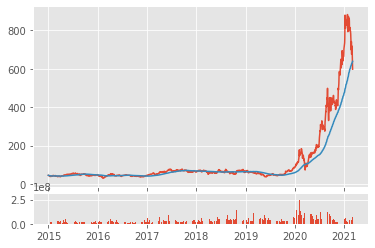

In [10]:
# first subplot starts at (0,0) on (6x1) grid, spanning 5 rows and 1 column
ax1 = plt.subplot2grid((6,1),(0,0),rowspan=5,colspan=1)
# second subplot starts at (5,0) on (6x1) grid, spanning 1 rows and 1 column
ax2 = plt.subplot2grid((6,1),(5,0),rowspan=1,colspan=1,sharex=ax1)

# graphing adj close and 100ma on the first axis, volume on the 2nd
ax1.plot(df.index,df['Adj Close'])
ax1.plot(df.index,df['100ma'])
ax2.bar(df.index,df['Volume'])

plt.show()

<br><br>**Candlestick/OHLC graph based on the Adj Close column**
<br>Condenses open, high, low, close data in one format.

In [11]:
import mplfinance as mpf
import matplotlib.dates as mdates

This creates OHLC data with ohlc resampling on a 10-day window.

We use both candlestick data and volume data. We resample the volume data as it is too granular as compared to 10D pricing data.

Default ohlc graph

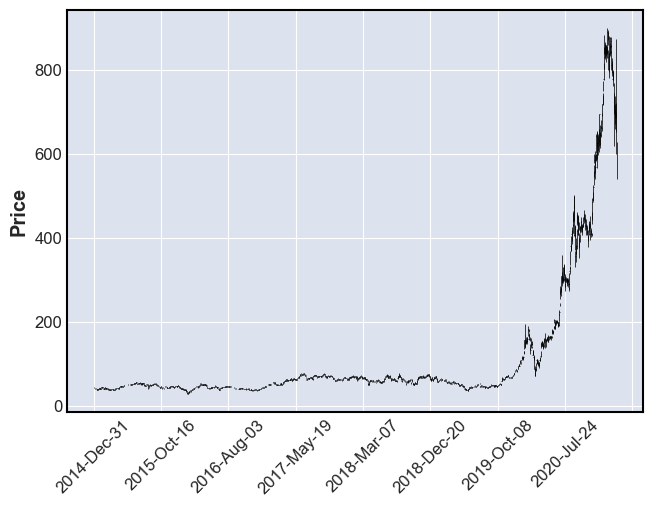

In [12]:
mpf.plot(df) 

We can plot moving averages with 'mav': 

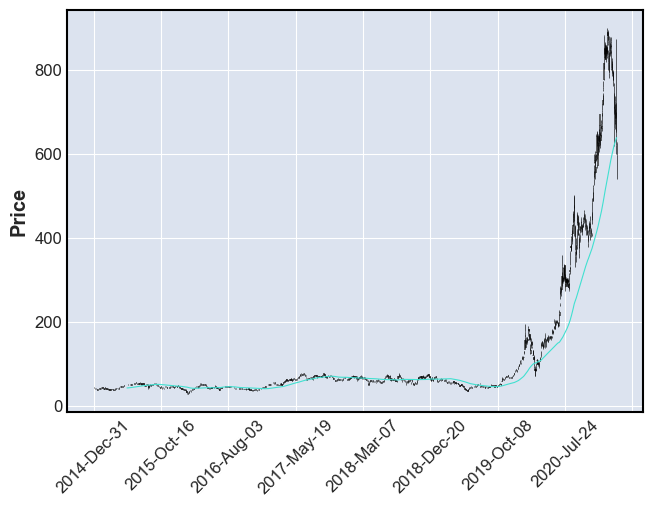

In [13]:
mpf.plot(df,type='candle',mav=100) 

Now, also display volume:

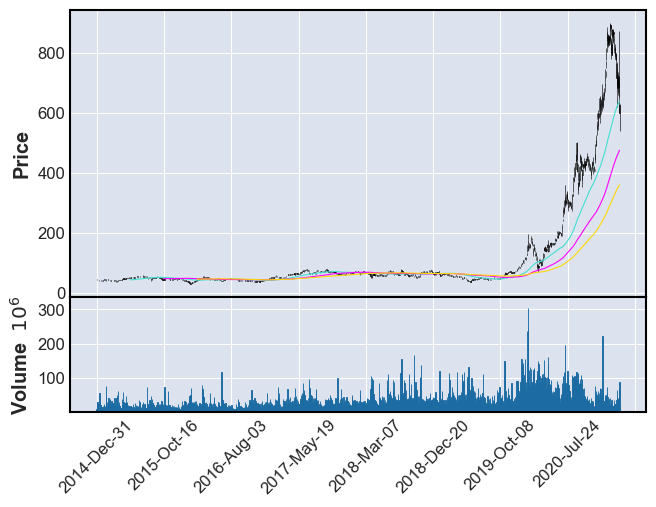

In [14]:
mpf.plot(df,type="candle",mav=(100,200,300),volume=True)

### Automating getting the S&P 500 list

We obtain the list from Wikipedia: [List of S&P 500 companies]('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies') <br>
The tickers on Wikipedia are organized on a table. We use Beatiful Soup to parse HTML.

In [15]:
import bs4 as bs
import pickle
import requests

pickle is just for convenience, the list should be updated in time.

In [16]:
def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text,'lxml')
    
    # Once we have 'soup', we can find the table of 
    # stock data by searcing for the wikitable sortable 
    # classes. (From the sourcecode.)

    table = soup.find('table',{'class':'wikitable sortable'})
    
    # Iterating through the table:
    tickers = []
    for row in table.findAll('tr')[1:]: # after the header row
        ticker = row.findAll('td')[0].text # grab text
        ticker = ticker[:-1] # remove '/n'
        # Yahoo translates official stock ticker as
        # BF-B, for example, instead of BF.B
        ticker = ticker.replace('.','-') 
        tickers.append(ticker)
        
    # Use pickle to save tickers
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

Note: 
```
ticker = ticker[:-1]
ticker = ticker.replace('.','-')
```
are essential for calls to Yahoo.

In [17]:
t = save_sp500_tickers()
t[:10]

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES']

### Getting all company pricing data for the S&P 500

In [18]:
import os

In [19]:
def get_data_from_yahoo(reload_sp500=False):
    
    # decision handler
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle","rb") as f:
            tickers = pickle.load(f)
            
    # Pull data from Yahoo for every stock, and store it.
    # For this, we: 
    # 1. Create a new directory, and
    # 2. Store stock data per company.
    
    # Initial directory:
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
        
    # Pull data:
    start = dt.datetime(2010,1,1)
    end = dt.datetime.now()
    for ticker in tickers:
        # Save progress just in case
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = web.DataReader(ticker,'yahoo',start,end)
            df.reset_index(inplace=True)
            df.set_index("Date",inplace=True)
            #df = df.drop("Symbol",axis=1)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print('Already have {}'.format(ticker))
            

In [20]:
get_data_from_yahoo()

Already have MMM
Already have ABT
Already have ABBV
Already have ABMD
Already have ACN
Already have ATVI
Already have ADBE
Already have AMD
Already have AAP
Already have AES
Already have AFL
Already have A
Already have APD
Already have AKAM
Already have ALK
Already have ALB
Already have ARE
Already have ALXN
Already have ALGN
Already have ALLE
Already have LNT
Already have ALL
Already have GOOGL
Already have GOOG
Already have MO
Already have AMZN
Already have AMCR
Already have AEE
Already have AAL
Already have AEP
Already have AXP
Already have AIG
Already have AMT
Already have AWK
Already have AMP
Already have ABC
Already have AME
Already have AMGN
Already have APH
Already have ADI
Already have ANSS
Already have ANTM
Already have AON
Already have AOS
Already have APA
Already have AAPL
Already have AMAT
Already have APTV
Already have ADM
Already have ANET
Already have AJG
Already have AIZ
Already have T
Already have ATO
Already have ADSK
Already have ADP
Already have AZO
Already have AV

### Combining all S&P 500 company prices into one DataFrame
In order to assess the data together, we join all the stock datasets together.

In [21]:
def compile_data():
    
    # Pull previously made list
    with open("sp500tickers.pickle","rb") as f:
        tickers = pickle.load(f)
        
    main_df = pd.DataFrame()
    
    # Read in each stock's dataframe:
    for count,ticker in enumerate(tickers):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date',inplace=True)
        
        # Focusing on the Adj Close column
        df.rename(columns={'Adj Close':ticker},inplace=True)
        df.drop(['Open','High','Low','Close','Volume'],1,inplace=True)
        
        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df,how="outer")
            
        if count%10==0:
            print(count)
    
    print(main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')

In [22]:
compile_data()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
                  MMM        ABT  ABBV  ABMD        ACN       ATVI       ADBE  \
Date                                                                            
2009-12-31  61.029957  19.901274   NaN  8.73  33.261742   9.956354  36.779999   
2010-01-04  61.288338  20.074522   NaN  8.74  33.718582  10.126624  37.090000   
2010-01-05  60.904442  19.912334   NaN  8.53  33.926979  10.144546  37.700001   
2010-01-06  61.768192  20.022911   NaN  8.40  34.287651  10.090778  37.619999   
2010-01-07  61.812481  20.188793   NaN  8.40  34.255581   9.848815  36.889999   

             AMD        AAP        AES  ...       WYNN        XEL        XRX  \
Date                                    ...                                    
2009-12-31  9.68  39.200214  10.265727  ...  38.204304  14.365969  14.284816   


### Creating S&P 500 company correlation table for relationships


In [23]:
import numpy as np

Visualization function:

In [24]:
def visualize_data():
    df = pd.read_csv('sp500_joined_closes.csv')
    
    # Correlation table
    df_corr = df.corr()
    print(df_corr.head())
    df_corr.to_csv('sp500corr.csv')
    
    # --- HEATMAP ---
    
    # Obtain data required
    data1 = df_corr.values # numpy array
    # Build figure and axis
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    
    # Use pcolor to create the heatmap
    heatmap1 = ax1.pcolor(data1,cmap=plt.cm.RdYlGn)
    
    # Colorbar (sidebar) as a scale
    fig1.colorbar(heatmap1)
    
    # Create x and y axis tick markers
    ax1.set_xticks(np.arange(data1.shape[1])+0.5,minor=False)
    ax1.set_yticks(np.arange(data1.shape[0])+0.5,minor=False)
    
    
    # Flip y-axis to make the graph easier to read 
    # Flip x-axis to be at the top of the graph to resemble
    # traditional correlation table
    ax1.invert_yaxis()
    ax1.xaxis.tick_top()
    
    # Add company names as labels to the ticks
    column_labels = df_corr.columns
    row_labels = df_corr.index
    ax1.set_xticklabels(column_labels)
    ax1.set_yticklabels(row_labels)
    
    # Rotate xticks (actual tickers) so they're vertical
    plt.xticks(rotation=90)
    # Colormap range is -1 to +1
    heatmap1.set_clim(-1,1)
    plt.tight_layout()
    plt.savefig("correlations.png",dpi=(300))
    plt.show()
    

           MMM       ABT      ABBV      ABMD       ACN      ATVI      ADBE  \
MMM   1.000000  0.715400  0.795949  0.824813  0.799622  0.862383  0.686863   
ABT   0.715400  1.000000  0.855957  0.817945  0.976496  0.875283  0.980063   
ABBV  0.795949  0.855957  1.000000  0.865391  0.906288  0.934085  0.882782   
ABMD  0.824813  0.817945  0.865391  1.000000  0.861858  0.897380  0.838432   
ACN   0.799622  0.976496  0.906288  0.861858  1.000000  0.931181  0.971705   

           AMD       AAP       AES  ...      WYNN       XEL       XRX  \
MMM   0.413937  0.749806  0.483340  ...  0.433569  0.788921  0.739644   
ABT   0.883243  0.635521  0.873300  ...  0.183676  0.959432  0.541438   
ABBV  0.758283  0.309364  0.655333  ...  0.014769  0.846130  0.413370   
ABMD  0.628565  0.599883  0.638044  ...  0.250454  0.816086  0.544513   
ACN   0.839981  0.674347  0.822038  ...  0.209100  0.977902  0.586380   

          XLNX       XYL       YUM      ZBRA       ZBH      ZION       ZTS  
MMM   0.747262 

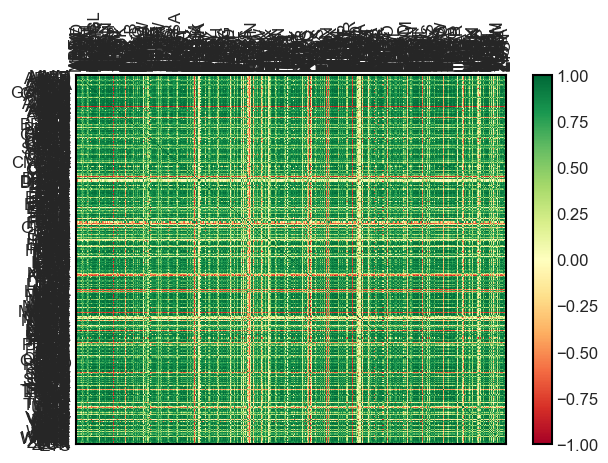

In [25]:
visualize_data()

We see that the majority of companies are positively correlated.<br>Several are very strongly correlated, and several are strongly negatively correlated.<br>Some companies are negatively correlated with most companies (straight red lines).<br>Several companies have no correlation at all.<br>We could, possibly, diversify investment by choosing companies with zero correlation over time.

## Preprocessing stock data for machine learning

Knowing that over time various companies have different relationships with each other, if a machine can recognize and fit these relationships, we could possibly predict changes in stock prices.

We use pricing changes on a specific day for all companies as features. Our labels are whether or not to actually buy a specific company. For example, stock APPL - take into account all company percent changes that day as features. Here, our label is whether or not APPL rose more than x% within the next y days (x,y are chosen). 

To begin with, a company is a buy if within the next 7 days, its price goes up more than 2%; and is a sell if its price goes down by more than 2% in the same 7 days.

We could make a strategy for this: if the algorithm says buy, we can buy, and place a 2% drop stop-loss (if the exchange price falls below this (or goes above if we're shorting), then exit the position). 

Processing data to help create labels:

In [28]:
def process_data_for_labels(ticker):
    
    # Takes single parameter 'ticker', 
    # training each model on a single company.
    
    hm_days = 7
    df = pd.read_csv('sp500_joined_closes.csv',index_col=0)
    tickers = df.columns.values.tolist()
    
    # Fill missing values
    df.fillna(0,inplace=True)
    
    # % change values for the next 7 days
    for i in range(1,hm_days+1):
        # Create new df columns for specific ticker
        # Get future values with .shift, which shifts a column up or down
        # Negative shift would shift the column up by i rows, which gives us
        # the future values i days in advance.
        df['{}_{}d'.format(ticker,i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
        
    df.fillna(0,inplace=True)
    return tickers, df  

### Creating targets for machine learning labels

We define a function that creates labels = dictating "buy", "sell", or "hold".<br>
If the price rises more than 2% in the next 7 days ==> buy.
If the price drops more than 2% in the next 7 days ==> sell.
If it does neither ==> hold (neither buy/sell).


In [29]:
def buy_sell_hold(*args):
    
    # *args are future price change columns.
    # Does movement exceed 2% in either direction?
    
    cols = [c for c in args]
    requirement = 0.02 # 2%
    for col in cols:
        if col > requirement: # buy
            return 1
        if col < -requirement: # sell
            return -1
    return 0 # hold

In [30]:
from collections import Counter

Counter lets us see the distributions of classes both in our dataset and in our algorithm's predictions.

We now define a function that takes any ticker, creates the needed dataset, and creates our "target" column which is our label. This has either a -1, 0, or 1 for each row, based on our function and the columns fed through:

In [33]:
def extract_featuresets(ticker):
    tickers, df = process_data_for_labels(ticker)
    
    df['{}_target'.format(ticker)] = list(map(buy_sell_hold,
                                              df['{}_1d'.format(ticker)],
                                              df['{}_2d'.format(ticker)],
                                              df['{}_3d'.format(ticker)],
                                              df['{}_4d'.format(ticker)],
                                              df['{}_5d'.format(ticker)],
                                              df['{}_6d'.format(ticker)],
                                              df['{}_7d'.format(ticker)] ))
    
    # Getting the distribution
    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('Data spread:',Counter(str_vals))
    
    # Cleaning up data
    df.fillna(0,inplace=True) # replace missing data with 0
    df = df.replace([np.inf,-np.inf],np.nan) # replace infinite values to NaNs
    df.dropna(inplace=True) # drop NaNs
    
    # Current features are day's stock prices (static numbers).
    # A better metric is every company's percent change that day.
    # Some companies change price before others, and we can possibly
    # profit on the lagging companies.
    # => Convert stock prices to % changes.
    df_vals = df[[ticker for ticker in tickers]].pct_change()
    df_vals = df_vals.replace([np.inf,-np.inf],0)
    df_vals.fillna(0,inplace=True)
    
    # Create features and labels
    X = df_vals.values
    y = df['{}_target'.format(ticker)].values
    
    return X,y,df
    

## Machine learning against S&P 500 company prices

In [36]:
from sklearn import svm, model_selection, neighbors
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

In [37]:
def do_ml(ticker):
    
    X,y,df = extract_featuresets(ticker)
    
    # Picks randomly, 1 of 3 ==> ~33% accuracy
    X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.25)
    
    # k nearest neighbors
    clf = neighbors.KNeighborsClassifier()
    clf.fit(X_train,y_train)
    confidence = clf.score(X_test,y_test)
    print('Accuracy:',confidence)
    predictions = clf.predict(X_test)
    print('Predicted class counts:',Counter(predictions))
    print()
    print()

In [38]:
do_ml('XOM')
do_ml('AAPL')
do_ml('ABT')

Data spread: Counter({'1': 970, '0': 962, '-1': 880})
Accuracy: 0.3712660028449502
Predicted class counts: Counter({0: 320, -1: 202, 1: 181})


Data spread: Counter({'1': 1346, '-1': 1025, '0': 441})
Accuracy: 0.36984352773826457
Predicted class counts: Counter({-1: 315, 1: 255, 0: 133})


Data spread: Counter({'1': 1113, '0': 877, '-1': 822})
Accuracy: 0.31436699857752487
Predicted class counts: Counter({0: 335, 1: 227, -1: 141})




This is better than 33%, but the training data isn't perfectly balanced.

In [39]:
def do_ml(ticker):
    
    X,y,df = extract_featuresets(ticker)
    
    # Picks randomly, 1 of 3 ==> ~33% accuracy
    X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.25)
    
    # Voting classifier
    clf = VotingClassifier([('lsvc',svm.LinearSVC()),
                            ('knn',neighbors.KNeighborsClassifier()),
                            ('rfor',RandomForestClassifier())])
    clf.fit(X_train,y_train)
    confidence = clf.score(X_test,y_test)
    print('Accuracy:',confidence)
    predictions = clf.predict(X_test)
    print('Predicted class counts:',Counter(predictions))
    print()
    print()

In [40]:
do_ml('XOM')
do_ml('AAPL')
do_ml('ABT')

Data spread: Counter({'1': 970, '0': 962, '-1': 880})
Accuracy: 0.37695590327169276
Predicted class counts: Counter({0: 262, -1: 254, 1: 187})


Data spread: Counter({'1': 1346, '-1': 1025, '0': 441})
Accuracy: 0.48079658605974396
Predicted class counts: Counter({1: 511, -1: 191, 0: 1})


Data spread: Counter({'1': 1113, '0': 877, '-1': 822})
Accuracy: 0.3755334281650071
Predicted class counts: Counter({1: 410, -1: 161, 0: 132})


